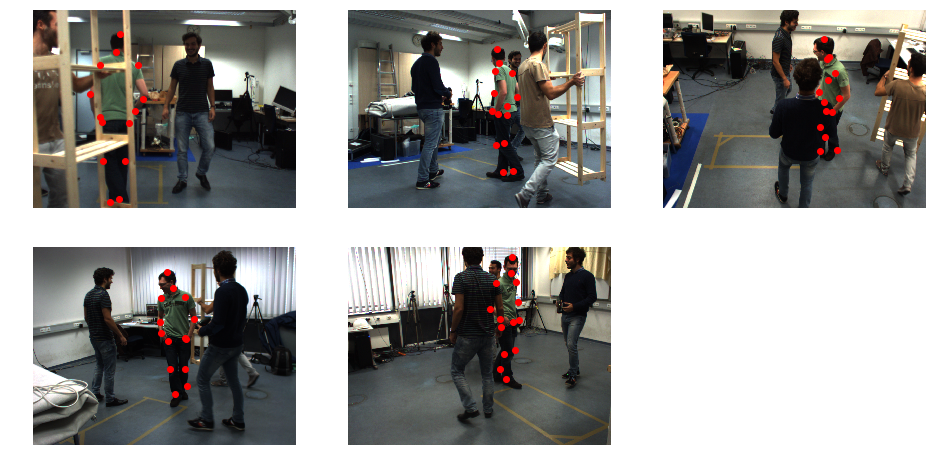

In [9]:
# Evaluation frames: [300 - 600].
# problematic frames: [539, 540]

import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import shelf

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']


FRAME = 520

X, Y, Calib = shelf.get(root, FRAME)

fig = plt.figure(figsize=(16,8))

COLORS = ['red', 'green', 'blue', 'yellow']

for cid in [0, 1, 2, 3, 4]:
    ax = fig.add_subplot(2, 3, cid+1)
    cam = Calib[cid]
    im = X[cid]
    ax.imshow(im)
    ax.axis('off')
    
    for pid, person in enumerate(Y):
        pts3d = person
        if pts3d is None:
            continue
        
        pts2d = cam.projectPoints(pts3d)
        for u, v in pts2d:
            ax.scatter(u, v, color=COLORS[pid])

plt.show()

step 1: elapsed 1.1772079467773438
step 2: elapsed 0.022461414337158203
step 3: elapsed 0.1942276954650879
step 4: elapsed 1.5698792934417725
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 0
	Inter:		 0
	Inter(choice):	 18
-------------------------------------------
	Time =  12  ms
	result: 0

	Total cost: 64.51279502082107

# valid points:		 79
# invalid points:	 15
step 5: elapsed 0.01667022705078125
(smart candidate selection) [
	Time =  8  ms
	result: 0

	Total cost: 28.105049116781124
] (smart candidate selection)
step 6: elapsed 0.01999521255493164

# detections 3


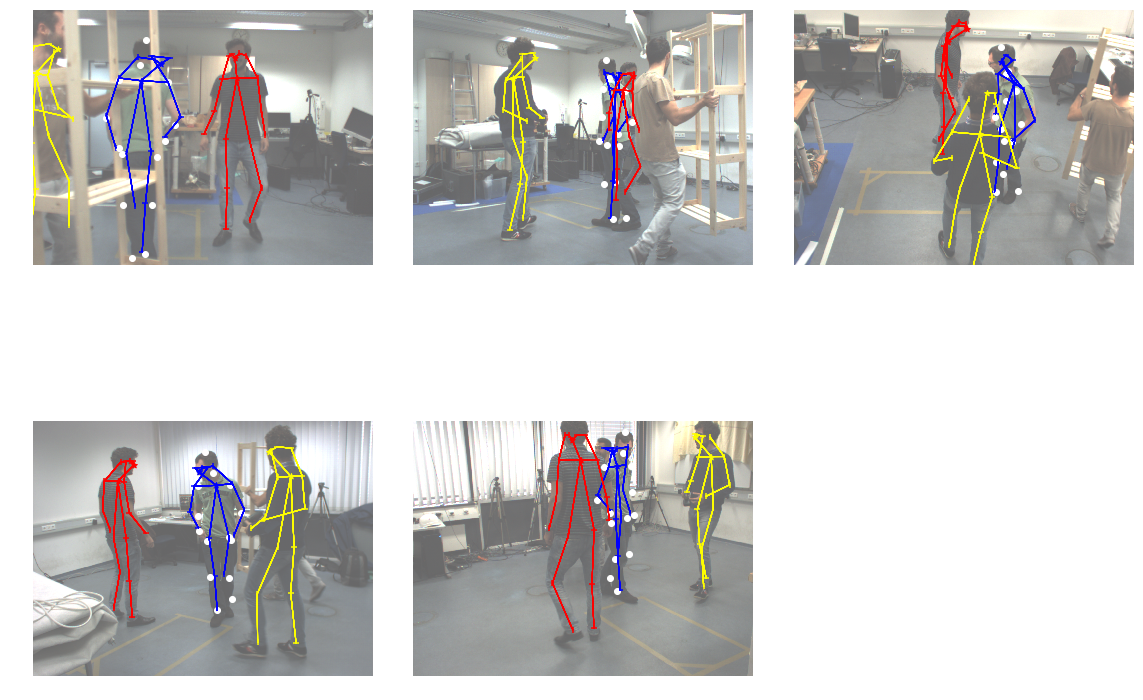

In [21]:
# ==================================
from mvpose import pose
from mvpose.settings import get_settings
import paf_loader
from mvpose.plot.limbs import draw_mscoco_human

Im, Y, Calib = shelf.get(root, FRAME)

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('shelf', 
                                                        Im, 
                                                        FRAME, 
                                                        dir=tmp)

#param = get_settings(scale_to_mm=1000)
# param = get_settings(
#     scale_to_mm=1000,
#     pp_conflict_overlap=0.8,
#     ms_radius=70,
#     ms_between_distance=70,
#     gp_max_radius=150
# )

param = get_settings(
    scale_to_mm=1000,
    ms_radius=400,
    ms_between_distance=100,
    gp_max_radius=130,
    pp_conflict_overlap=0.5
)


Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                                  settings=param,
                                  debug=True)

print('\n# detections', len(detections))

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['blue', 'red', 'yellow', 'cyan', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.tight_layout()
plt.show()

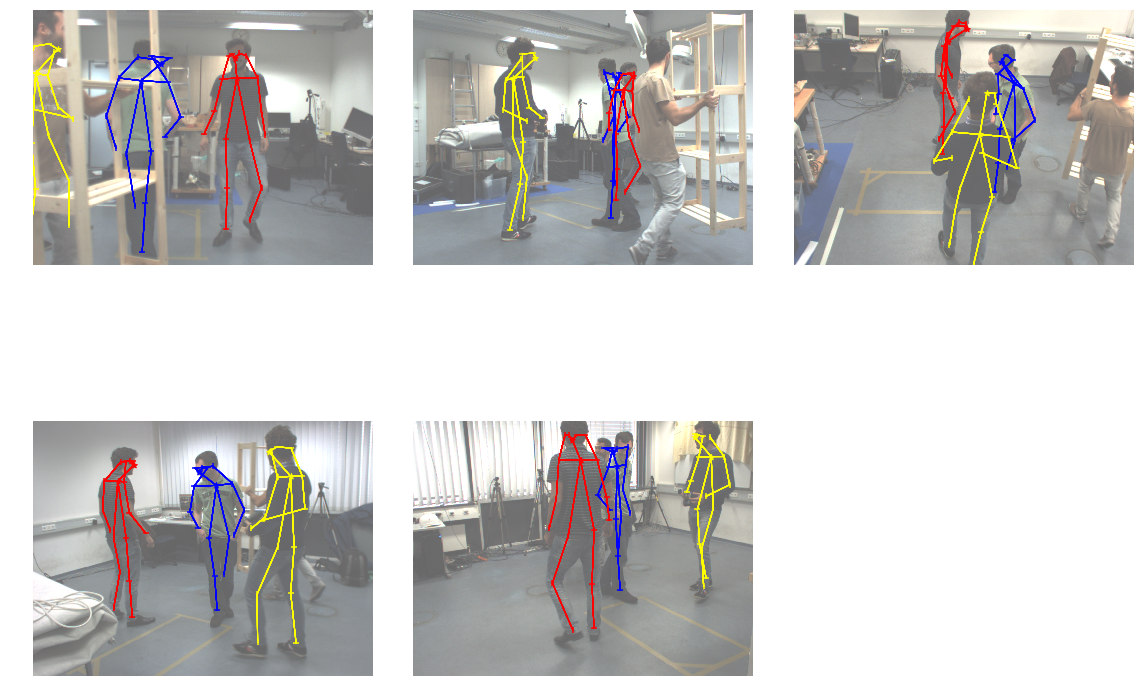

In [28]:
fig = plt.figure(figsize=(16,12))

colors = ['blue', 'red', 'yellow', 'cyan', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2, 3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid])
        
plt.tight_layout()
plt.show()

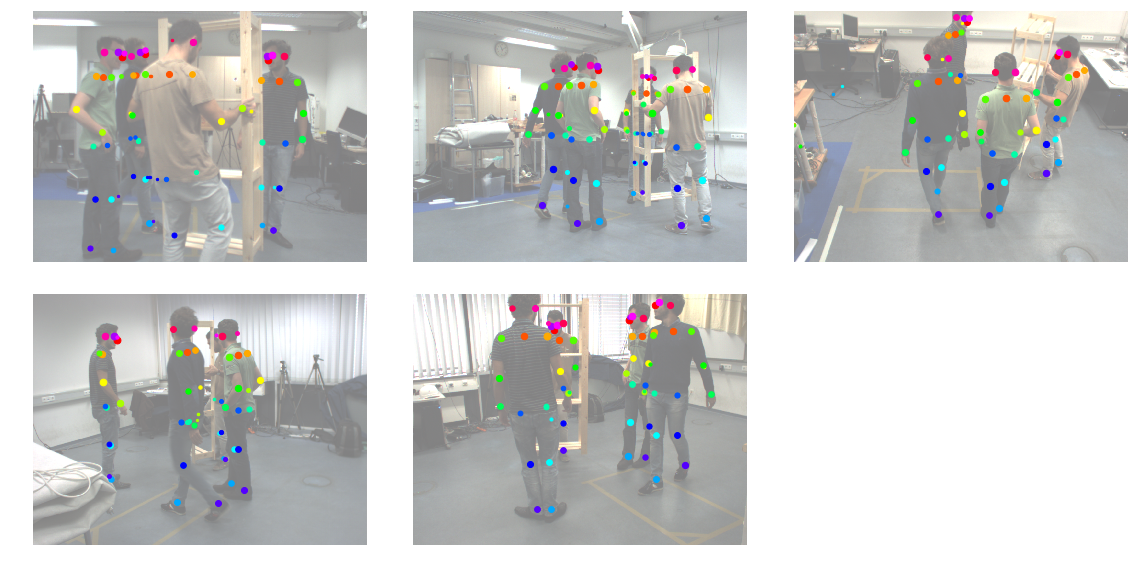

In [5]:
colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(2, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
        
plt.tight_layout()
plt.show()

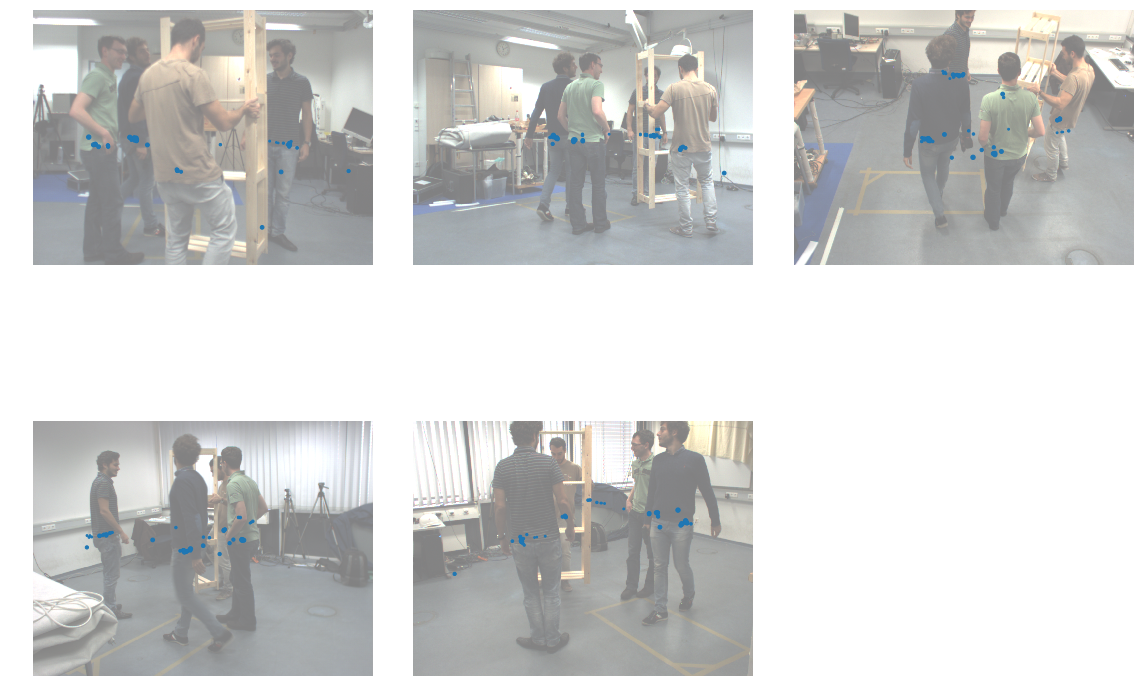

In [6]:
import mvpose.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(2, 3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
 
plt.tight_layout()
plt.show()